In [1]:
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import contextlib
import logging

import numpy as np
import pandas as pd
import seaborn as sns

import anndata as ad
import spatialdata as sd
import spatialdata_plot
from spatialdata import SpatialData, polygon_query
from spatialdata_io import xenium

import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib_venn import venn3
from matplotlib.colors import ListedColormap

from lightning.pytorch import seed_everything

import os
import mygene
import copy

from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import scipy.stats as stats
from scipy.stats import gaussian_kde, pearsonr, ks_2samp, mannwhitneyu, chi2_contingency
from scipy.signal import find_peaks

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
varrone_df = pd.read_csv('/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_cell_types.csv')

In [3]:
adata_big = sc.read_h5ad("/mnt/ptemp/virginia/project/breast_cancer_atlas_cellxgene_epithelial.h5ad")

In [4]:
adata_small = sc.read('/mnt/ptemp/virginia/project/adata_new.h5ad')

In [5]:
xenium = sd.read_zarr("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")

In [6]:
epithelial_cells = sc.read_h5ad("epithelial_cells_cell_type_prediction_filtered.h5ad")

In [7]:
# Normalizzo i counts per cella (per correggere per la library size)
sc.pp.normalize_total(epithelial_cells, inplace=True)
sc.pp.log1p(epithelial_cells)                     

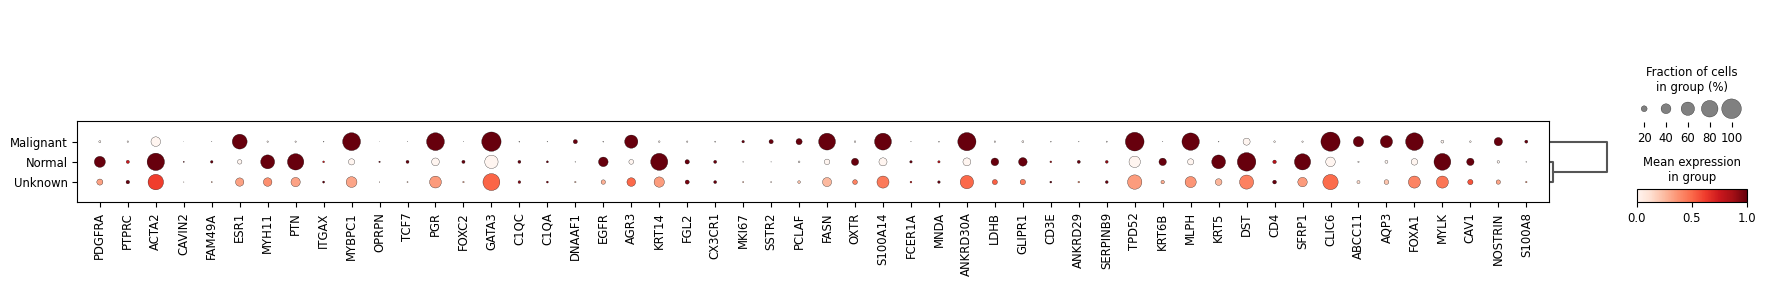

In [8]:
# 1. DGE
sc.tl.rank_genes_groups(
    epithelial_cells,
    groupby='cell_type_prediction',
    method='wilcoxon')

# 2. Estraggo e filtro i geni per ciascun gruppo
top_genes_dict = {}
filtered_gene_cutoff = 0.58  # logFC
pval_cutoff = 0.01
top_n = 20

group_names = epithelial_cells.uns['rank_genes_groups']['names'].dtype.names

for group in group_names:
    df = sc.get.rank_genes_groups_df(epithelial_cells, group=group)

    filtered = df[
        (df['logfoldchanges'] > filtered_gene_cutoff) &
        (df['pvals'] < pval_cutoff)    ]

    gene_ids = filtered.sort_values(by='logfoldchanges', ascending=False)['names'].head(top_n).tolist()
    top_genes_dict[group] = gene_ids

# 3. Estraggo i gruppi anche fuori dal loop
top_genes_malignant = top_genes_dict.get('Malignant', [])
top_genes_normal = top_genes_dict.get('Normal', [])
top_genes_unknown = top_genes_dict.get('Unknown', [])


# 4. Calcolo lo score per ogni gruppo
for group, genes in top_genes_dict.items():
    sc.tl.score_genes(epithelial_cells, gene_list=genes, score_name=f"{group}_signature_score")

# 5. Visualizzazione: Dotplot e Heatmap dei geni filtrati
# Unisco tutti i geni distintivi dei gruppi
all_top_genes = list(set(sum(top_genes_dict.values(), [])))

sc.pl.dotplot(
    epithelial_cells,
    var_names=all_top_genes,
    groupby='cell_type_prediction',
    standard_scale='var',
    dendrogram=True,
    save='dotplot_top_genes.pdf')

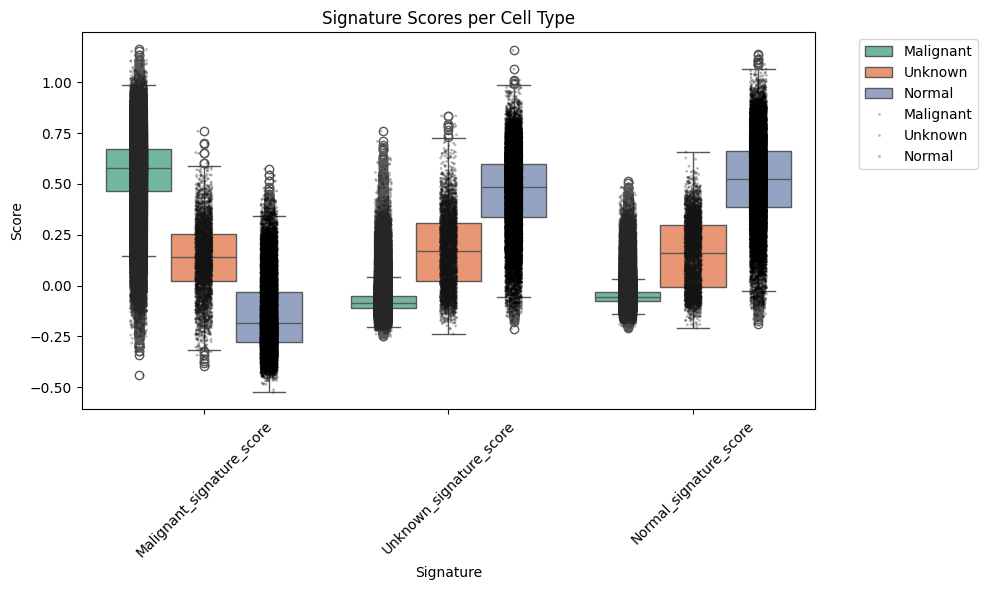

In [9]:
# Costruisco un DataFrame "melted" per seaborn
df = epithelial_cells.obs[['cell_type_prediction', 
                 'Malignant_signature_score', 
                 'Unknown_signature_score', 
                 'Normal_signature_score']].copy()

# Ordino le categorie come desiderato
desired_order = ['Malignant', 'Unknown', 'Normal']
df['cell_type_prediction'] = pd.Categorical(df['cell_type_prediction'], categories=desired_order, ordered=True)

# Converto in long format per seaborn
df_melted = df.melt(id_vars='cell_type_prediction', 
                    var_name='Signature', 
                    value_name='Score')

# Boxplot con overlay di punti
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Signature', y='Score', hue='cell_type_prediction', 
            palette='Set2', hue_order=desired_order)
sns.stripplot(data=df_melted, x='Signature', y='Score', hue='cell_type_prediction', 
              dodge=True, color='black', alpha=0.3, size=2, hue_order=desired_order)

plt.title('Signature Scores per Cell Type')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
# Verifico quanto sono significativi gli score (ovvero controllo lo score medio per ogni gruppo, per ciascuna signature)
df.groupby('cell_type_prediction')[
    ['Malignant_signature_score', 'Unknown_signature_score', 'Normal_signature_score']].mean()

# lo score Unknown_signature_score è più altro nelle Normal, quindi non è discriminativo

Malignant_signature_score  Unknown_signature_score  \
cell_type_prediction                                                       
Malignant                              0.558039                -0.072980   
Unknown                                0.134698                 0.172228   
Normal                                -0.144003                 0.461100   

                      Normal_signature_score  
cell_type_prediction                          
Malignant                          -0.047561  
Unknown                             0.155406  
Normal                              0.519084

Normal_signature_score Estimated threshold: 0.124
[Malignant_signature_score] Less than two peaks detected: unable to estimate the threshold.


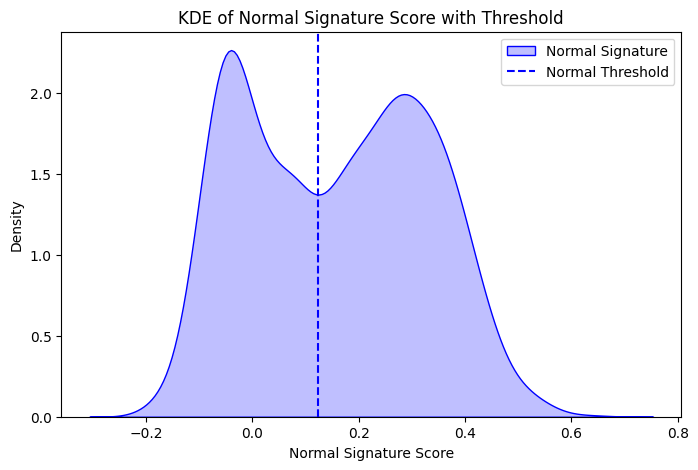

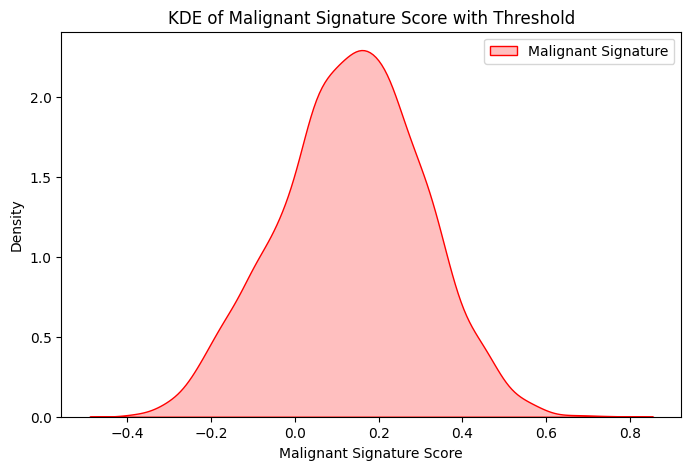

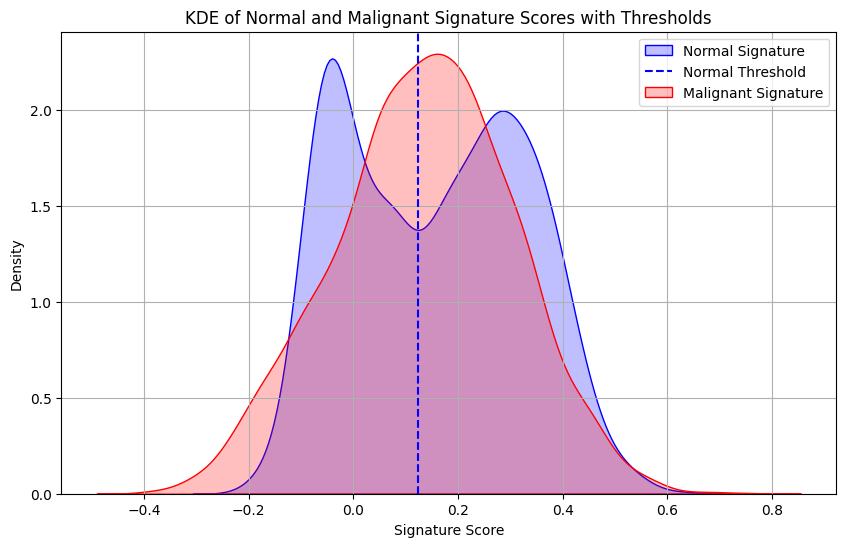


Correlation between the two signatures (epithelial Unknown cells):
                           Normal_signature_score  Malignant_signature_score
Normal_signature_score                    1.00000                    0.24854
Malignant_signature_score                 0.24854                    1.00000


In [11]:
# 1. Seleziono solo le cellule Unknown
df_unknown = df[df['cell_type_prediction'] == 'Unknown'].copy()

# 2. Funzione migliorata per trovare soglia e classificare
def analyze_signature(df, column, direction='greater'):
    scores = df[column].dropna().values
    
    if len(scores) < 10:
        print(f"[{column}] Troppi pochi valori per stimare la soglia.")
        return df, None, None

    # Calcola KDE usando gaussian_kde
    kde = gaussian_kde(scores)
    x_vals = np.linspace(min(scores), max(scores), 1000)
    y_vals = kde(x_vals)

    # Trova i picchi
    peaks, _ = find_peaks(y_vals)
    if len(peaks) < 2:
        print(f"[{column}] Less than two peaks detected: unable to estimate the threshold.")
        return df, None, None

    # Trova la valle tra i due picchi principali
    peak1, peak2 = sorted(peaks[:2])
    valley_idx = np.argmin(y_vals[peak1:peak2])
    threshold = x_vals[peak1 + valley_idx]

    print(f"{column} Estimated threshold: {threshold:.3f}")

    # Crea nuova colonna di classificazione
    class_column = f"new_class_{column.split('_')[0].lower()}"
    if direction == 'greater':
        df[class_column] = df[column].apply(lambda x: 'Malignant' if x > threshold else 'Normal')
    else:
        df[class_column] = df[column].apply(lambda x: 'Malignant' if x < threshold else 'Normal')

    return df, threshold, class_column

# 3. Applica la funzione alle due signature
df_unknown, threshold_normal, class_col_normal = analyze_signature(df_unknown, 'Normal_signature_score', direction='less')
df_unknown, threshold_malignant, class_col_malignant = analyze_signature(df_unknown, 'Malignant_signature_score', direction='greater')

# 4. Plot separato per Normal
plt.figure(figsize=(8, 5))
sns.kdeplot(df_unknown['Normal_signature_score'].dropna(), fill=True, color='blue', label='Normal Signature')
if threshold_normal:
    plt.axvline(threshold_normal, color='blue', linestyle='--', label='Normal Threshold')
plt.title('KDE of Normal Signature Score with Threshold')
plt.xlabel('Normal Signature Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# 5. Plot separato per Malignant
plt.figure(figsize=(8, 5))
sns.kdeplot(df_unknown['Malignant_signature_score'].dropna(), fill=True, color='red', label='Malignant Signature')
if threshold_malignant:
    plt.axvline(threshold_malignant, color='red', linestyle='--', label='Malignant Threshold')
plt.title('KDE of Malignant Signature Score with Threshold')
plt.xlabel('Malignant Signature Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# 6. Plot combinato
plt.figure(figsize=(10, 6))
sns.kdeplot(df_unknown['Normal_signature_score'].dropna(), fill=True, color='blue', label='Normal Signature')
if threshold_normal:
    plt.axvline(threshold_normal, color='blue', linestyle='--', label='Normal Threshold')
sns.kdeplot(df_unknown['Malignant_signature_score'].dropna(), fill=True, color='red', label='Malignant Signature')
if threshold_malignant:
    plt.axvline(threshold_malignant, color='red', linestyle='--', label='Malignant Threshold')
plt.title('KDE of Normal and Malignant Signature Scores with Thresholds')
plt.xlabel('Signature Score')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

# 7. Correlazione tra le due firme
correlation = df_unknown[['Normal_signature_score', 'Malignant_signature_score']].corr()
print("\nCorrelation between the two signatures (epithelial Unknown cells):")
print(correlation)


[Normal_signature_score] Bimodal: Estimated threshold = 0.125
[Malignant_signature_score] Unimodal: Threshold set at 75th percentile = 0.253


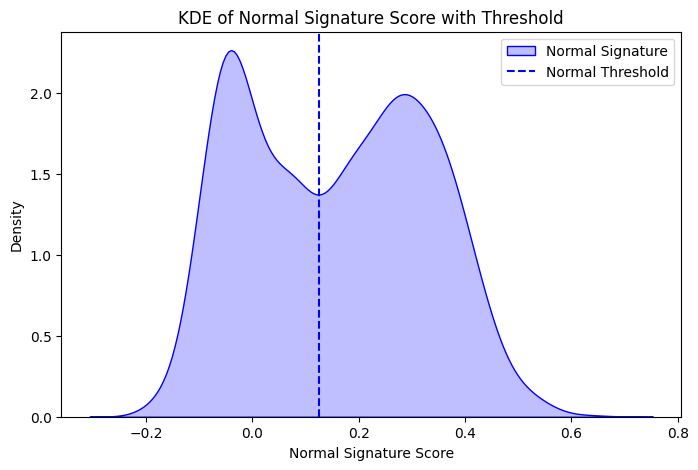

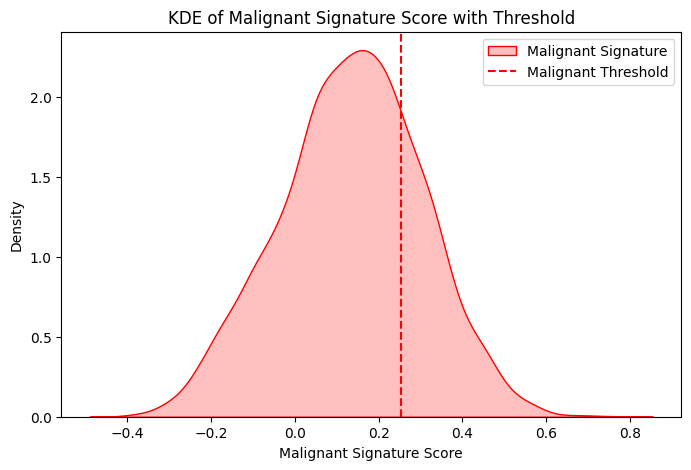

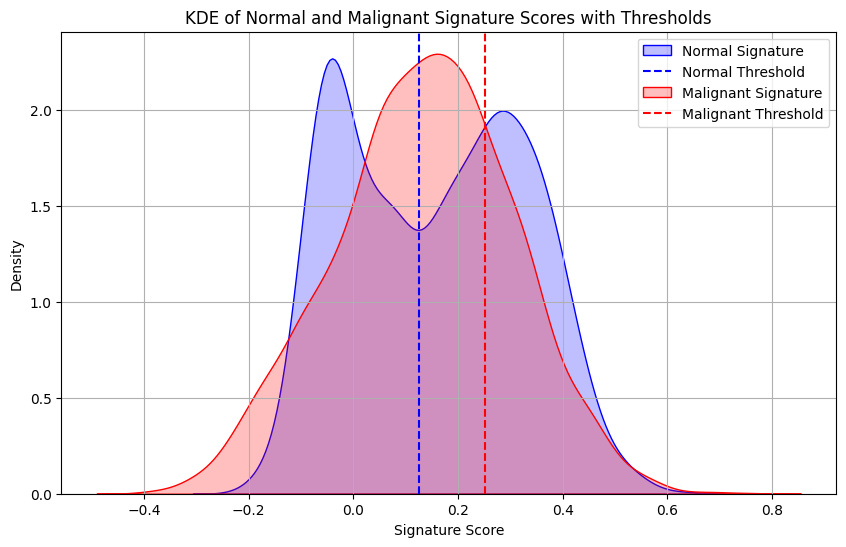


Correlation between the two signatures (epithelial Unknown cells):
                           Normal_signature_score  Malignant_signature_score
Normal_signature_score                    1.00000                    0.24854
Malignant_signature_score                 0.24854                    1.00000


In [12]:
# 1. Seleziona solo le cellule Unknown
df_unknown = df[df['cell_type_prediction'] == 'Unknown'].copy()

# 2. Funzione aggiornata per trovare soglia e classificare
def analyze_signature(df, column, direction='greater', percentile=0.75):
    scores = df[column].dropna().values
    
    # Calcola KDE
    kde_plot = sns.kdeplot(scores, bw_adjust=1)
    x_vals, y_vals = kde_plot.get_lines()[0].get_data()
    plt.close()  # evita di visualizzare il plot
    
    # Trova i picchi
    peaks, _ = find_peaks(y_vals)
    
    if len(peaks) >= 2:
        # Bimodale: soglia tra i due picchi principali
        peak1, peak2 = sorted(peaks[:2])
        valley_idx = np.argmin(y_vals[peak1:peak2])
        threshold = x_vals[peak1 + valley_idx]
        print(f"[{column}] Bimodal: Estimated threshold = {threshold:.3f}")
    else:
        # Unimodale: usa il percentile
        threshold = np.percentile(scores, percentile*100)
        print(f"[{column}] Unimodal: Threshold set at {percentile*100:.0f}th percentile = {threshold:.3f}")
    
    # Classificazione
    class_column = f"new_class_{column.split('_')[0].lower()}"
    if direction == 'greater':
        df[class_column] = df[column].apply(lambda x: 'Malignant' if x > threshold else 'Normal')
    else:
        df[class_column] = df[column].apply(lambda x: 'Malignant' if x < threshold else 'Normal')
    
    return df, threshold, class_column

# 3. Applica la funzione alle due signature
df_unknown, threshold_normal, class_col_normal = analyze_signature(df_unknown, 'Normal_signature_score', direction='less')
df_unknown, threshold_malignant, class_col_malignant = analyze_signature(df_unknown, 'Malignant_signature_score', direction='greater')

# 4. Plot separato per Normal
plt.figure(figsize=(8, 5))
sns.kdeplot(df_unknown['Normal_signature_score'].dropna(), fill=True, color='blue', label='Normal Signature')
plt.axvline(threshold_normal, color='blue', linestyle='--', label='Normal Threshold')
plt.title('KDE of Normal Signature Score with Threshold')
plt.xlabel('Normal Signature Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# 5. Plot separato per Malignant
plt.figure(figsize=(8, 5))
sns.kdeplot(df_unknown['Malignant_signature_score'].dropna(), fill=True, color='red', label='Malignant Signature')
plt.axvline(threshold_malignant, color='red', linestyle='--', label='Malignant Threshold')
plt.title('KDE of Malignant Signature Score with Threshold')
plt.xlabel('Malignant Signature Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# 6. Plot combinato
plt.figure(figsize=(10, 6))
sns.kdeplot(df_unknown['Normal_signature_score'].dropna(), fill=True, color='blue', label='Normal Signature')
plt.axvline(threshold_normal, color='blue', linestyle='--', label='Normal Threshold')
sns.kdeplot(df_unknown['Malignant_signature_score'].dropna(), fill=True, color='red', label='Malignant Signature')
plt.axvline(threshold_malignant, color='red', linestyle='--', label='Malignant Threshold')
plt.title('KDE of Normal and Malignant Signature Scores with Thresholds')
plt.xlabel('Signature Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# 7. Correlazione tra le due signature
correlation = df_unknown[['Normal_signature_score', 'Malignant_signature_score']].corr()
print("\nCorrelation between the two signatures (epithelial Unknown cells):")
print(correlation)

In [13]:
pd.crosstab(df_unknown['new_class_normal'], df_unknown['new_class_malignant'])

new_class_malignant  Malignant  Normal
new_class_normal                      
Malignant                  370    1571
Normal                     708    1662

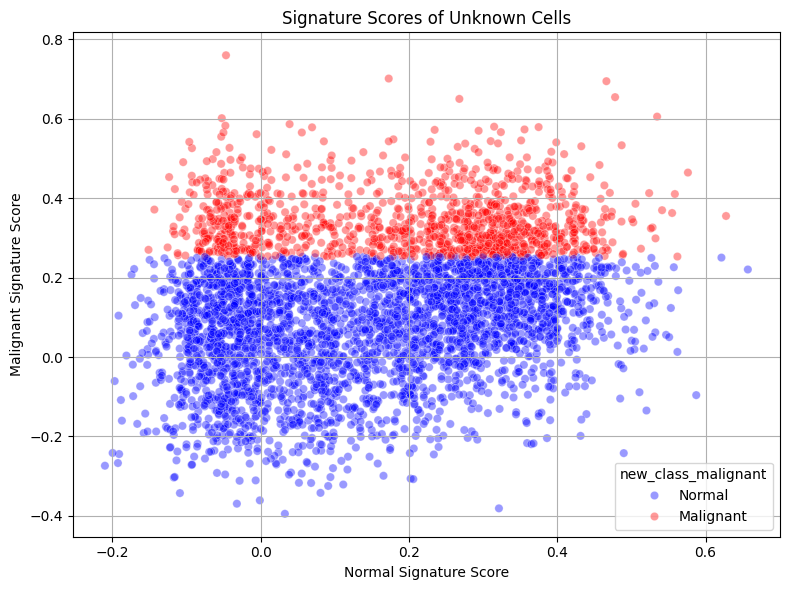

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_unknown,
    x='Normal_signature_score',
    y='Malignant_signature_score',
    hue='new_class_malignant',  # oppure usa 'new_class_normal'
    alpha=0.4,
    palette={'Normal': 'blue', 'Malignant': 'red'}
)
plt.title('Signature Scores of Unknown Cells')
plt.xlabel('Normal Signature Score')
plt.ylabel('Malignant Signature Score')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/scatter_new_class_malignant.pdf', format='pdf')
plt.show()

In [15]:
match = (df_unknown['new_class_normal'] == df_unknown['new_class_malignant']).sum()
total = len(df_unknown)
print(f"Agreement between the two classifications: {match}/{total} ({100 * match/total:.2f}%)")

Agreement between the two classifications: 2032/4311 (47.14%)


In [16]:
# DGE: Unknown vs Malignant
sc.tl.rank_genes_groups(
    epithelial_cells,
    groupby='cell_type_prediction',
    groups=['Unknown'],
    reference='Malignant',
    method='wilcoxon')

# Salvo i risultati in un DataFrame
dge_um = sc.get.rank_genes_groups_df(epithelial_cells, group='Unknown')

In [17]:
# DGE: Unknown vs Normal
sc.tl.rank_genes_groups(
    epithelial_cells,
    groupby='cell_type_prediction',
    groups=['Unknown'],
    reference='Normal',
    method='wilcoxon')

# Salvo i risultati in un DataFrame
dge_un = sc.get.rank_genes_groups_df(epithelial_cells, group='Unknown')

In [18]:
# Estraggo i geni significativi con p-value < 0.01 e logFC > 0.58
sig_um = dge_um[(dge_um['pvals_adj'] < 0.01) & (dge_um['logfoldchanges'] > 0.58)]
sig_un = dge_un[(dge_un['pvals_adj'] < 0.01) & (dge_un['logfoldchanges'] > 0.58)]

# Geni significativi comuni con logFC in entrambe le condizioni
common_df = pd.merge(
    sig_um[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'logFC_UM'}),
    sig_un[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'logFC_UN'}),
    on='names')

print(f"Candidate marker genes of the Unknown cells (overexpressed in both comparisons): {len(common_df)}")
display(common_df.sort_values(by='logFC_UM', key=abs, ascending=False))

Candidate marker genes of the Unknown cells (overexpressed in both comparisons): 7


names  logFC_UM  logFC_UN
0    TCIM  1.625417  1.584808
1  CCDC80  1.593636  1.047891
6     DPT  1.501426  1.858803
5    GJB2  1.166832  1.215615
4   SFRP4  1.003335  2.073271
2  CXCL12  0.985716  0.888535
3     LUM  0.898820  1.000946

In [19]:
adata = xenium.table

# Unisci i dati sul campo 'cell_id'
adata.obs = adata.obs.merge(varrone_df[['cell_id', 'level1', 'level2']],
                            on='cell_id',
                            how='left')

/tmp/ipykernel_2074735/120584968.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  adata = xenium.table


In [20]:
# Analizzo in quali cell type (colonna level_1) sono maggiormente espressi i geni LUM, CXCL12, CCDC80 e TCIM nell'oggetto SpatialData (Xenium)

# Calcolo l'espressione media per cell_type(level_1)

# Estraggo i dati di espressione dei geni selezionati
adata_selected = adata[:, genes]

# Creo un DataFrame con le espressioni e il tipo cellulare
df = pd.DataFrame(adata_selected.X.toarray(), columns=genes, index=adata.obs.index)
df['cell_type'] = adata.obs['level2'].values

# Calcola l'espressione media per ogni gene in ciascun cell type
mean_expression = df.groupby('cell_type')[genes].mean()

# Ordina decrescente per ogni gene (facoltativo)
for gene in genes:
    print(f"\n {gene} - cell types with highest average expression:")
    display(mean_expression[[gene]].sort_values(by=gene, ascending=False).head())


 MYLK - cell types with highest average expression:


MYLK
cell_type                  
Normal_epithelial  4.130989
Pericyte           2.050190
Endothelial        0.949352
Fibroblast         0.442336
Mast_cell          0.238489


 ITGAX - cell types with highest average expression:


ITGAX
cell_type               
Myeloid         0.955093
Mast_cell       0.444707
Adipocyte       0.441176
B_cell          0.156546
Dendritic cell  0.141892


 FCER1A - cell types with highest average expression:


FCER1A
cell_type          
Myeloid    0.523798
Mast_cell  0.289650
Adipocyte  0.273933
B_cell     0.171189
T_cell     0.126287


 MYH11 - cell types with highest average expression:


MYH11
cell_type                  
Pericyte           1.911850
Normal_epithelial  1.740430
Endothelial        0.249396
Fibroblast         0.089801
Dendritic cell     0.060811


 SFRP1 - cell types with highest average expression:


SFRP1
cell_type                  
Normal_epithelial  2.746379
Adipocyte          0.453287
Fibroblast         0.344114
Plasma_cell        0.171898
Mast_cell          0.147580


 KRT14 - cell types with highest average expression:


KRT14
cell_type                     
Normal_epithelial     3.077198
Malignant_epithelial  0.053933
Plasma_cell           0.040876
Endothelial           0.039810
Fibroblast            0.038390


 FGL2 - cell types with highest average expression:


FGL2
cell_type            
Myeloid      1.767113
Adipocyte    0.815167
Plasma_cell  0.552920
T_cell       0.463470
B_cell       0.458713


 PTPRC - cell types with highest average expression:


PTPRC
cell_type               
T_cell          2.449536
B_cell          1.828985
Myeloid         1.514244
Dendritic cell  1.378378
Adipocyte       1.032007


 C1QC - cell types with highest average expression:


C1QC
cell_type            
Myeloid      0.880124
Adipocyte    0.633218
Plasma_cell  0.271898
T_cell       0.233769
B_cell       0.219188


 PTN - cell types with highest average expression:


PTN
cell_type                  
Normal_epithelial  2.851411
Pericyte           0.232978
Fibroblast         0.210651
Endothelial        0.133333
Plasma_cell        0.113869


 CX3CR1 - cell types with highest average expression:


CX3CR1
cell_type            
Myeloid      0.925840
Mast_cell    0.159386
Adipocyte    0.154556
T_cell       0.150063
Plasma_cell  0.144161


 C1QA - cell types with highest average expression:


C1QA
cell_type            
Myeloid      0.639345
Adipocyte    0.589100
Plasma_cell  0.248175
T_cell       0.197138
B_cell       0.183044


 SERPINB9 - cell types with highest average expression:


SERPINB9
cell_type               
Dendritic cell  1.655405
T_cell          0.348456
B_cell          0.343774
Myeloid         0.312184
Plasma_cell     0.283577


 ACTA2 - cell types with highest average expression:


ACTA2
cell_type                  
Pericyte           6.667537
Normal_epithelial  4.990864
Fibroblast         4.949841
Endothelial        2.954965
Myeloid            2.070946


 CAV1 - cell types with highest average expression:


CAV1
cell_type            
Endothelial  3.019214
Pericyte     2.733835
Adipocyte    1.857266
Fibroblast   0.698929
Plasma_cell  0.523723


 LDHB - cell types with highest average expression:


LDHB
cell_type            
Adipocyte    1.416667
Endothelial  0.754361
Pericyte     0.628011
T_cell       0.477981
B_cell       0.456738


 MNDA - cell types with highest average expression:


MNDA
cell_type               
Myeloid         0.576467
Dendritic cell  0.378378
Adipocyte       0.367359
B_cell          0.197513
T_cell          0.163143


 DST - cell types with highest average expression:


DST
cell_type                  
Normal_epithelial  5.167853
Pericyte           1.193974
Endothelial        1.067358
Fibroblast         0.974354
Adipocyte          0.780277


 CD3E - cell types with highest average expression:


CD3E
cell_type               
T_cell          2.317801
Dendritic cell  0.479730
Adipocyte       0.478950
B_cell          0.299204
Plasma_cell     0.208759


 CD4 - cell types with highest average expression:


CD4
cell_type               
Myeloid         1.791994
Dendritic cell  1.222973
Adipocyte       1.194348
T_cell          0.853327
B_cell          0.541461

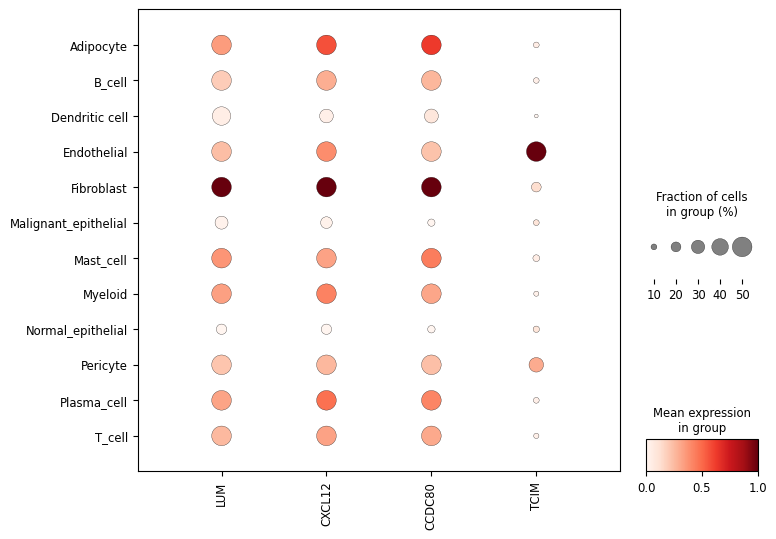

In [21]:
# Dotplot per visualizzare contemporaneamente l’espressione media per cell type (level1) e la % di cellule che esprimono ciascun gene (dot size)

# Geni di interesse
genes = ['LUM', 'CXCL12', 'CCDC80', 'TCIM']

# Dotplot: mostra media e percentuale di espressione per gene e cell type
sc.pl.dotplot(
    adata,
    var_names=genes,
    groupby='level2',
    standard_scale='var',  
    dot_max=0.5,           
    figsize=(8, 6),
    dendrogram=False,      
    show=True)

In [33]:
df_expr = epithelial_cells.to_df().copy()
df_expr['cell_type_prediction'] = epithelial_cells.obs['cell_type_prediction'].values

# Funzione per calcolare % di espressione > 0
def percent_expressed(df, group_col):
    groups = df[group_col].unique()
    result = {}
    for group in groups:
        group_df = df[df[group_col] == group].drop(columns=[group_col])
        percent = (group_df > 0).sum() / group_df.shape[0] * 100
        result[group] = percent
    return pd.DataFrame(result)

percent_expr = percent_expressed(df_expr, 'cell_type_prediction')

genes_specific_to_unknown = percent_expr[
    (percent_expr['Unknown'] > 20) &     # abbassa soglia espressione in Unknown
    (percent_expr['Malignant'] < 20) &  # abbassa soglia in Malignant
    (percent_expr['Normal'] < 20)]

print(genes_specific_to_unknown.sort_values('Unknown', ascending=False).head(20))

# CCDC80 è un gene che codifica una proteina extracellulare contenente un dominio coiled-coil, coinvolta nella regolazione della crescita 
# cellulare, adesione e differenziazione. Questa proteina è considerata un potenziale oncosoppressore, con espressione spesso ridotta in vari 
# tumori, dove la sua perdita favorisce proliferazione e invasività cellulare.
# Il gene CCDC80 è espresso in circa il 20% delle cellule "Unknown" (cioè circa 1 cellula su 5 di questo gruppo ha espressione > 0).

        Malignant    Unknown     Normal
CCDC80  13.055271  20.278574  15.335978


In [31]:
# Possibili interpretazioni biologiche:
# 1. Regolazione differenziale: CCDC80 potrebbe avere un ruolo specifico nelle cellule "Unknown", magari collegato a particolari processi 
# cellulari o stadi di differenziazione non ancora definiti.
# 2. Marcatori di stato cellulare: Essendo espressa diversamente, potrebbe aiutare a distinguere o caratterizzare meglio le cellule "Unknown" 
# rispetto a Malignant o Normal, utile per studi di classificazione o identificazione cellulare.
# 3. Ruolo funzionale: Se CCDC80 è un oncosoppressore come indicato, la sua espressione variabile potrebbe influenzare crescita, adesione o 
#invasività cellulare, implicando potenziali differenze biologiche rilevanti.
# 4. Biomarker potenziale: Differenze marcate possono rendere questo gene un candidato per biomarcatori diagnostici o prognostici, 
# specialmente se l’"Unknown" rappresenta uno stato patologico o di transizione.

In [32]:
# ***SECONDO DATASET FILTRATO, BILANCIATO e DATI MOLECOLARI SCALATI***

epithelial_cells_down_scaled = sc.read_h5ad("epi_bal_scaled.h5ad")

In [33]:
# 1. DGE sul dataset downsampled & scaled
sc.tl.rank_genes_groups(
    epithelial_cells_down_scaled,
    groupby='cell_type_prediction',
    method='wilcoxon')

# 2. Estrazione e filtraggio dei geni
top_genes_dict = {}
filtered_gene_cutoff = 0.58
pval_cutoff = 0.01
top_n = 20

group_names = epithelial_cells_down_scaled.uns['rank_genes_groups']['names'].dtype.names

for group in group_names:
    df = sc.get.rank_genes_groups_df(epithelial_cells_down_scaled, group=group)

    filtered = df[
        (df['logfoldchanges'] > filtered_gene_cutoff) &
        (df['pvals'] < pval_cutoff)
    ]

    gene_ids = filtered.sort_values(by='logfoldchanges', ascending=False)['names'].head(top_n).tolist()
    top_genes_dict[group] = gene_ids

# 3. Controllo quanti geni validi per ciascun gruppo
for group, genes in top_genes_dict.items():
    print(group, len(genes))

Malignant 0
Normal 0
Unknown 1


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


In [34]:
# Dataset originale
#a = epthelial_cells
#dataset_name = 'epithelial_cells'

# ANALISI RIPETUTE CON IL CAMPIONE BILANCIATO E DATI SCALATI
a = epithelial_cells_down_scaled
dataset_name = "epithelial_cells_down_scaled"

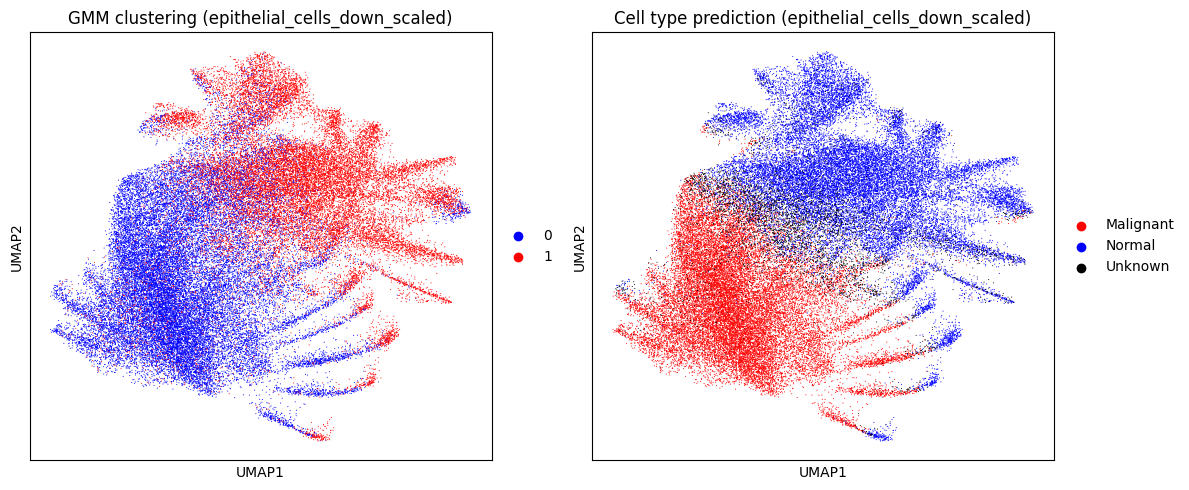

cell_type_prediction  Malignant  Normal  Unknown
GMM_cluster                                     
0                         23619    4725     2451
1                          1381   20275     1860


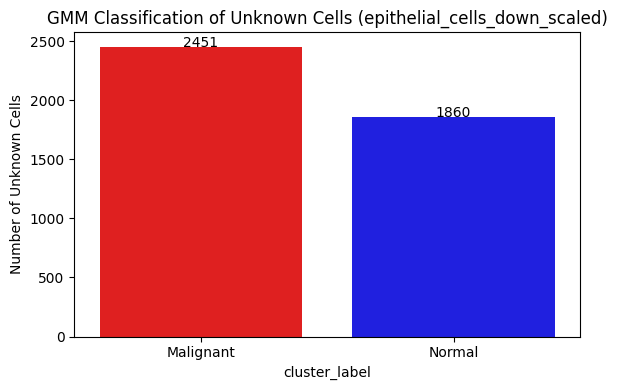

In [35]:
# 1. Unione dei top genes calcolati sul dataset originale
top_all = list(set(top_genes_normal + top_genes_malignant + top_genes_unknown))
genes_present = [gene for gene in top_all if gene in a.var_names]

# 2. Estrai matrice di espressione solo per i geni delle signature
epithelial_cells_sig = a[:, genes_present].copy()

# 3. GMM sui geni delle signature
X = epithelial_cells_sig.X.toarray() if not isinstance(epithelial_cells_sig.X, np.ndarray) else epithelial_cells_sig.X
gmm = GaussianMixture(n_components=2, random_state=42)
labels = gmm.fit_predict(X)
a.obs['GMM_cluster'] = labels.astype(str)

# 4. UMAP sull'intero dataset
sc.pp.neighbors(a)
sc.tl.umap(a)

# 5. UMAP plot: GMM vs Cell Type
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(
    a,
    color='GMM_cluster',
    palette=['blue', 'red'],
    title=f'GMM clustering ({dataset_name})',
    ax=axes[0],
    show=False)

sc.pl.umap(
    a,
    color='cell_type_prediction',
    palette={'Normal': 'blue', 'Malignant': 'red', 'Unknown': 'black'},
    title=f'Cell type prediction ({dataset_name})',
    ax=axes[1],
    show=False)

plt.tight_layout()
os.makedirs("figures", exist_ok=True)
fig.savefig(f'figures/umap_gmm_vs_celltype_{dataset_name}.png', dpi=300)
plt.show()

# 6. Tabella incrociata
print(pd.crosstab(a.obs['GMM_cluster'], a.obs['cell_type_prediction']))

# 7. Barplot: classificazione delle Unknown
unknown_cells = a[a.obs['cell_type_prediction'] == 'Unknown']
cluster_label_map = { '0': 'Malignant', '1': 'Normal' }
df_plot = unknown_cells.obs[['GMM_cluster']].copy()
df_plot['cluster_label'] = df_plot['GMM_cluster'].map(cluster_label_map)

desired_order = ['Malignant', 'Normal']
desired_palette = {'Malignant': 'red', 'Normal': 'blue'}

plt.figure(figsize=(6,4))
ax = sns.countplot(data=df_plot, x='cluster_label',
                   order=desired_order, palette=desired_palette)

plt.title(f'GMM Classification of Unknown Cells ({dataset_name})')
plt.ylabel('Number of Unknown Cells')

# Aggiungi etichette sopra le barre
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1,
            int(height), ha="center", fontsize=10)

plt.tight_layout()
plt.savefig(f'figures/barplot_unknown_gmm_classification_{dataset_name}.png', dpi=300)
plt.show()

▶️ Cluster 0 - n_cells: 30795


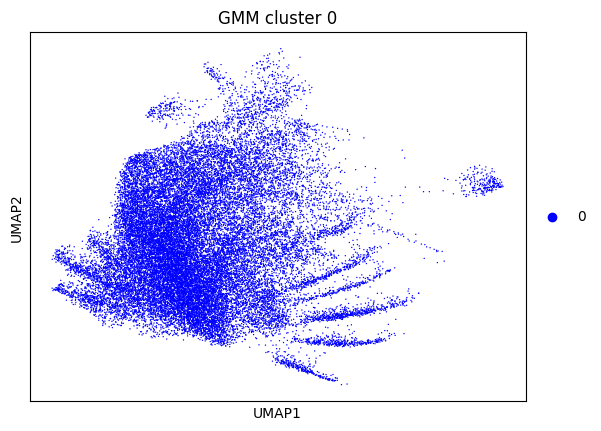

▶️ Cluster 1 - n_cells: 23516


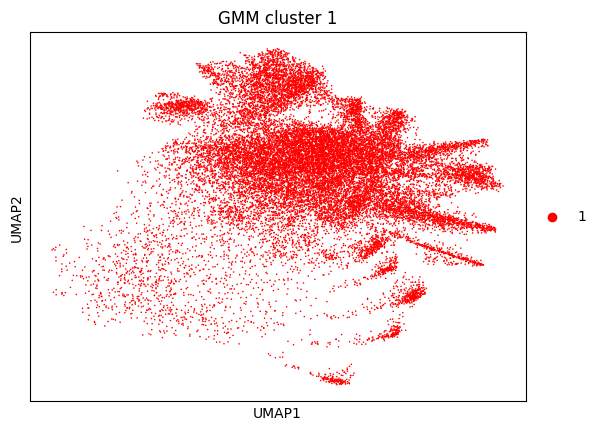

▶️ Cell type: Malignant - n_cells: 25000


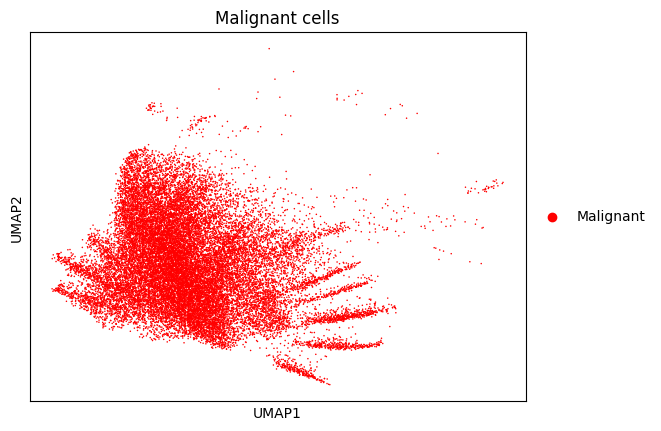

▶️ Cell type: Normal - n_cells: 25000


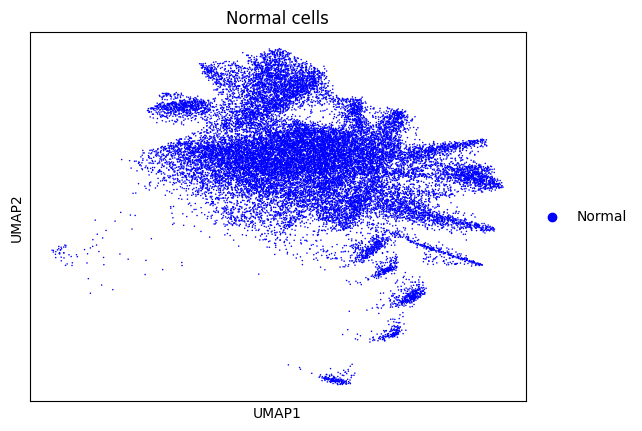

▶️ Cell type: Unknown - n_cells: 4311


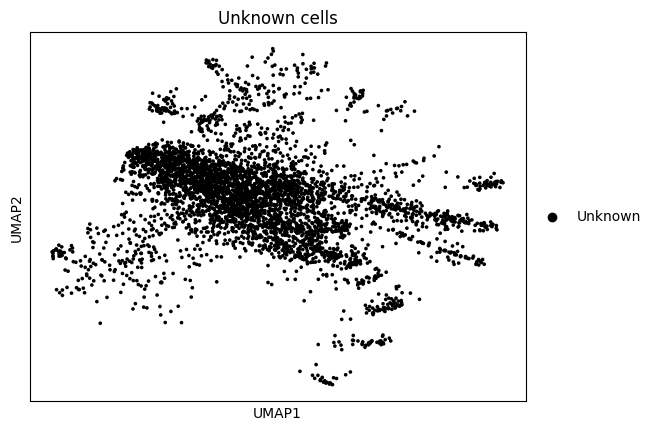

In [36]:
# PLOT SEPARATI PER OGNI CLUSTER di GMM 
for i, color in zip(['0', '1'], ['blue', 'red']):
    subset = a[a.obs['GMM_cluster'].astype(str) == i]
    print(f"▶️ Cluster {i} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        sc.pl.umap(subset, color='GMM_cluster', title=f'GMM cluster {i}',
                   palette=[color], show=True)

# PLOT SEPARATI PER OGNI CLUSTER di cell_type_prediction
for ct, color in zip(['Malignant', 'Normal', 'Unknown'], ['red', 'blue', 'black']):
    subset = a[a.obs['cell_type_prediction'].astype(str) == ct]
    print(f"▶️ Cell type: {ct} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        sc.pl.umap(subset,
                   color='cell_type_prediction',
                   title=f'{ct} cells',
                   palette=[color],
                   show=True)

In [37]:
# FUNZIONE per plottare due UMAP affiancati: a sinistra GMM clustering con Unknown evidenziate, a destra solo Unknown in rosso.

def plot_gmm_vs_unknown_highlight(
    adata,
    feature_key: str,
    cluster_key: str = 'GMM_cluster',
    title_left: str = 'GMM clustering of Unknown cells (highlighted)',
    title_right: str = 'Cell Type Prediction (highlight Unknown)',
    save_path: str = None):
   
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Maschere
    mask_known = adata.obs['cell_type_prediction'].isin(['Normal', 'Malignant'])
    mask_unknown = adata.obs['cell_type_prediction'] == 'Unknown'

    # --- SINISTRA ---
    sc.pl.umap(
        adata[mask_known],
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray'},
        size=10,
        alpha=0.3,
        ax=axes[0],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color=cluster_key,
        palette=['blue', 'red'],
        size=10,
        alpha=0.5,
        ax=axes[0],
        show=False,
        legend_loc='right')
    axes[0].set_title(title_left)
    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='GMM cluster')

    # --- DESTRA ---
    sc.pl.umap(
        adata,
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray', 'Unknown': 'lightgray'},
        size=10,
        alpha=0.5,
        ax=axes[1],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color='cell_type_prediction',
        palette={'Unknown': 'red'},
        size=10,
        alpha=0.5,
        ax=axes[1],
        show=False)
    axes[1].set_title(title_right)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()

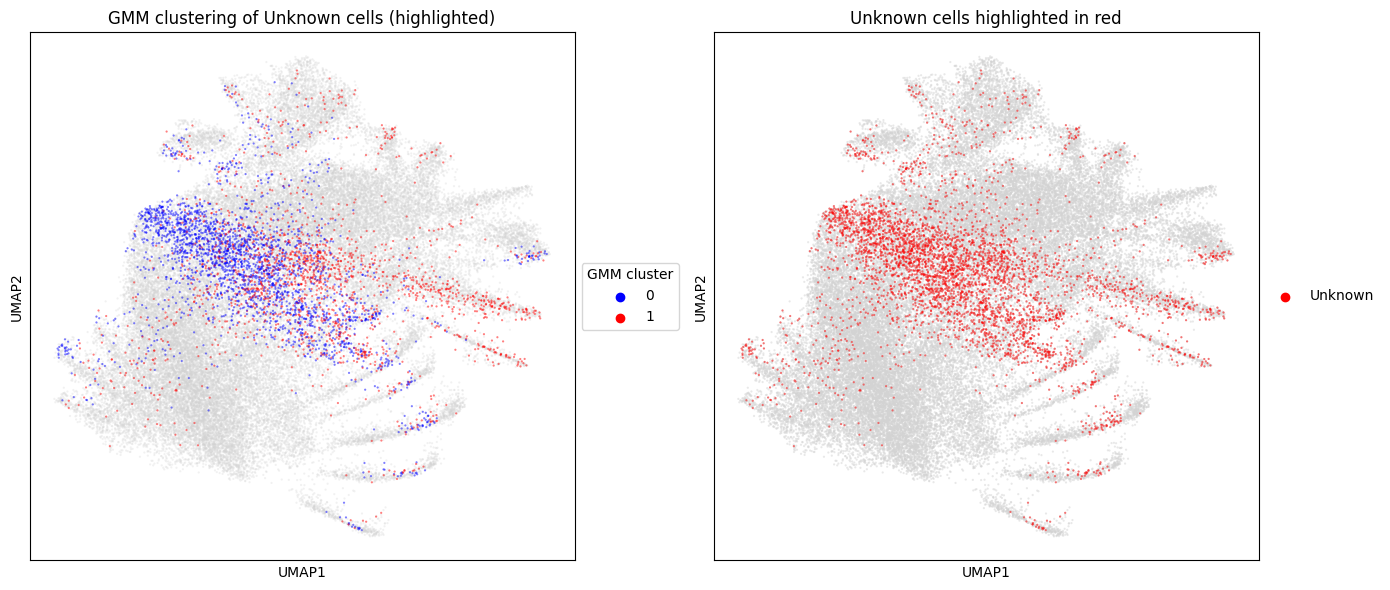

In [38]:
# Definisci il path dinamico usando dataset_name
save_path = f'figures/umap_gmm_unknown_highlighted_{dataset_name}.png'

# Chiamata alla funzione con salvataggio dinamico
plot_gmm_vs_unknown_highlight(
    adata=a,
    feature_key='cell_type_prediction',
    cluster_key='GMM_cluster',
    title_left='GMM clustering of Unknown cells (highlighted)',
    title_right='Unknown cells highlighted in red',
    save_path=save_path  # salva la figura con nome dinamico)

/tmp/ipykernel_1292423/860400454.py:15: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_down = normal_sample.concatenate(malignant_sample, unknown_cells)
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


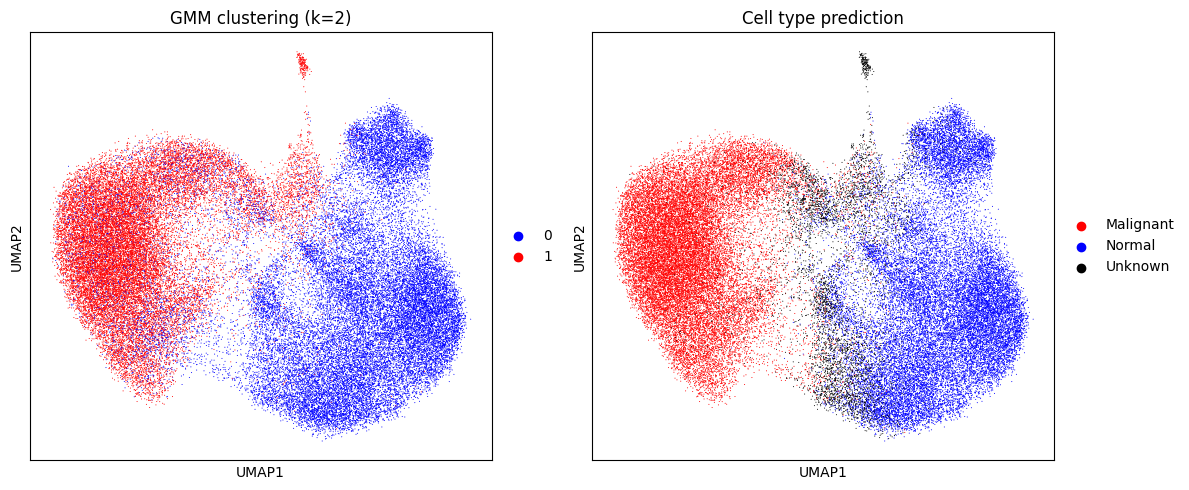

/tmp/ipykernel_1292423/860400454.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


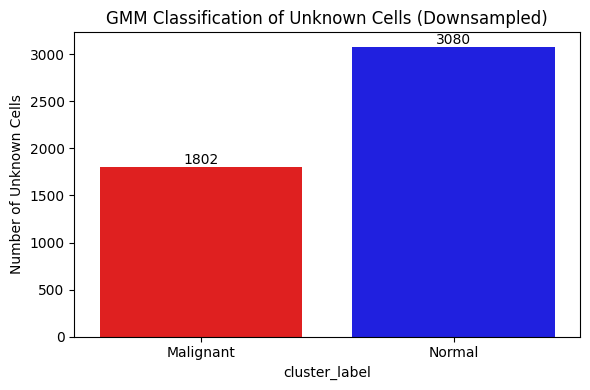

cell_type_prediction  Malignant  Normal  Unknown
GMM_cluster                                     
0                          3327   24595     3080
1                         21673     405     1802


In [64]:
# DATASET INIZIALE SOLO CON DOWNSAMPLING 

# 1. Filtra cellule Normal, Malignant, Unknown
mask_nmu = epithelial_cells.obs['cell_type_prediction'].isin(['Normal', 'Malignant', 'Unknown'])
adata_nmu = epithelial_cells[mask_nmu].copy()

# 2. Estrai gruppi separatamente
normal_cells = adata_nmu[adata_nmu.obs['cell_type_prediction'] == 'Normal']
malignant_cells = adata_nmu[adata_nmu.obs['cell_type_prediction'] == 'Malignant']
unknown_cells = adata_nmu[adata_nmu.obs['cell_type_prediction'] == 'Unknown']

# 3. Downsampling: 25k Normal + 25k Malignant
normal_sample = normal_cells[np.random.choice(normal_cells.shape[0], 25000, replace=False)].copy()
malignant_sample = malignant_cells[np.random.choice(malignant_cells.shape[0], 25000, replace=False)].copy()

# 4. Combina
adata_down = normal_sample.concatenate(malignant_sample, unknown_cells)

# 5. Seleziona solo le signature presenti
top_all = list(set(top_genes_normal + top_genes_malignant))
genes_present = [gene for gene in top_all if gene in adata_down.var_names]
adata_down_sig = adata_down[:, genes_present].copy()

# 6. Preprocessing delle signature
sc.pp.normalize_total(adata_down_sig)
sc.pp.log1p(adata_down_sig)

# 7. GMM sulle signature (non su UMAP!)
X = adata_down_sig.X.toarray() if not isinstance(adata_down_sig.X, np.ndarray) else adata_down_sig.X
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X)

# 8. Aggiungi GMM cluster a `adata_down`
adata_down.obs['GMM_cluster'] = gmm_labels.astype(str)

# 9. UMAP per visualizzazione
sc.pp.neighbors(adata_down)
sc.tl.umap(adata_down)

# 10. Plot UMAP GMM vs cell type
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(
    adata_down, 
    color='GMM_cluster', 
    palette=['blue', 'red'], 
    ax=axes[0], 
    show=False, 
    title='GMM clustering (k=2)')

sc.pl.umap(
    adata_down, 
    color='cell_type_prediction', 
    palette={'Normal': 'blue', 'Malignant': 'red', 'Unknown': 'black'},
    ax=axes[1], 
    show=False, 
    title='Cell type prediction')

plt.tight_layout()
fig.savefig('figures/umap_downsampled_gmm_plus_unknown.png', dpi=300)
plt.show()

# 11. Barplot: classificazione delle Unknown
unknown_cells = adata_down[adata_down.obs['cell_type_prediction'] == 'Unknown']
df_plot = unknown_cells.obs[['GMM_cluster']].copy()
df_plot['cluster_label'] = df_plot['GMM_cluster'].map({'0': 'Normal', '1': 'Malignant'})

plt.figure(figsize=(6,4))
ax = sns.countplot(
    data=df_plot,
    x='cluster_label',
    order=['Malignant', 'Normal'],
    palette={'Malignant': 'red', 'Normal': 'blue'}
)
plt.title('GMM Classification of Unknown Cells (Downsampled)')
plt.ylabel('Number of Unknown Cells')

# ➕ Aggiunta dei valori interi sopra le barre
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 1,
        f'{int(height)}',  # ← Qui si forza il numero intero
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.savefig('figures/barplot_unknown_gmm_downsampled.png', dpi=300)
plt.show()


# 12. Matrice di contingenza tra GMM e Cell Type
print(pd.crosstab(adata_down.obs['GMM_cluster'], adata_down.obs['cell_type_prediction']))


▶️ Cluster 0 - n_cells: 31002


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


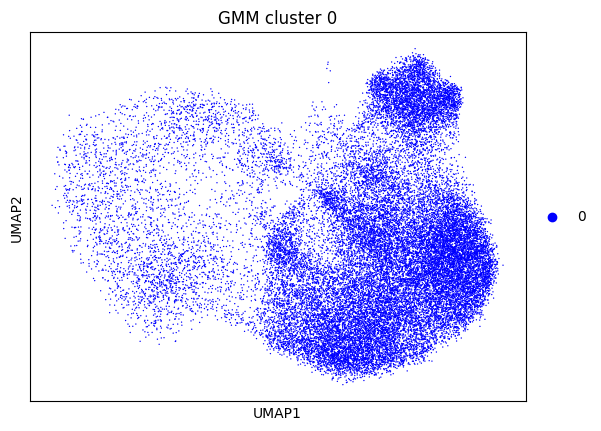

▶️ Cluster 1 - n_cells: 23880


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


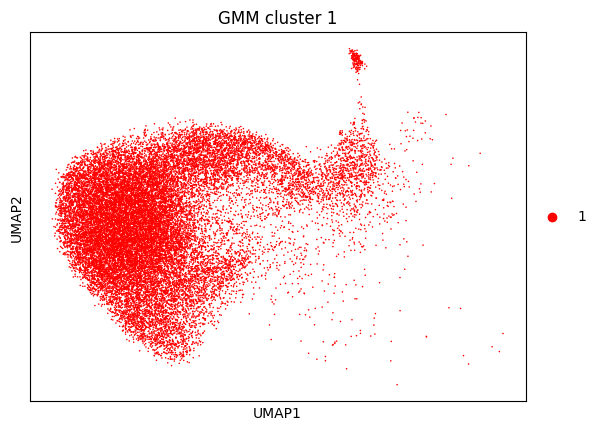

▶️ Cell type: Malignant - n_cells: 25000


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


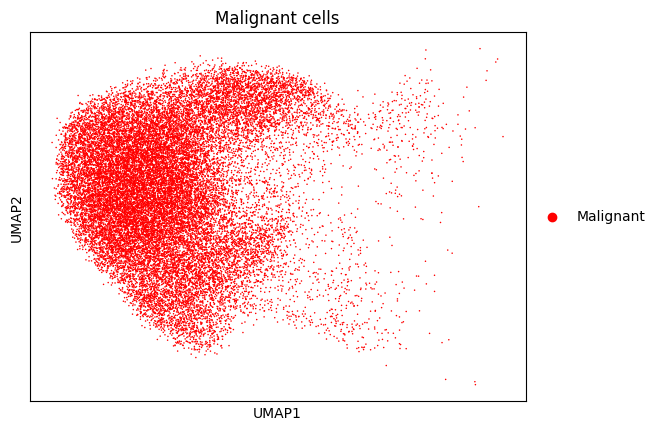

▶️ Cell type: Normal - n_cells: 25000


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


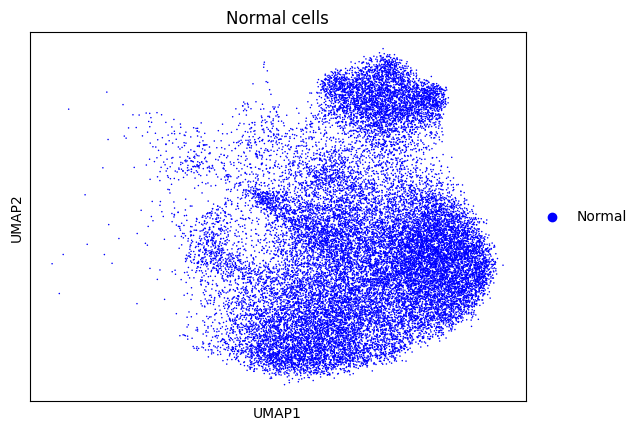

▶️ Cell type: Unknown - n_cells: 4882


/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


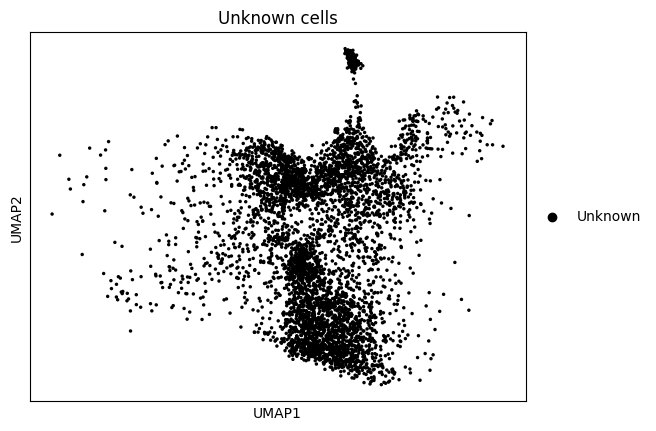

In [69]:
# PLOT SEPARATI PER OGNI CLUSTER di GMM 

for i, color in zip(['0', '1'], ['blue', 'red']):
    subset = adata_down[adata_down.obs['GMM_cluster'].astype(str) == i]
    print(f"▶️ Cluster {i} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        sc.pl.umap(subset, color='GMM_cluster', title=f'GMM cluster {i}',
                   palette=[color], show=True)

# PLOT SEPARATI PER OGNI CLUSTER di cell_type_prediction

for ct, color in zip(['Malignant', 'Normal', 'Unknown'], ['red', 'blue', 'black']):
    subset = adata_down[adata_down.obs['cell_type_prediction'].astype(str) == ct]
    print(f"▶️ Cell type: {ct} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        sc.pl.umap(subset,
                   color='cell_type_prediction',
                   title=f'{ct} cells',
                   palette=[color],
                   show=True)

/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/mnt/ndata/virginia/conda/cellcharter_env/lib/python3.12/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


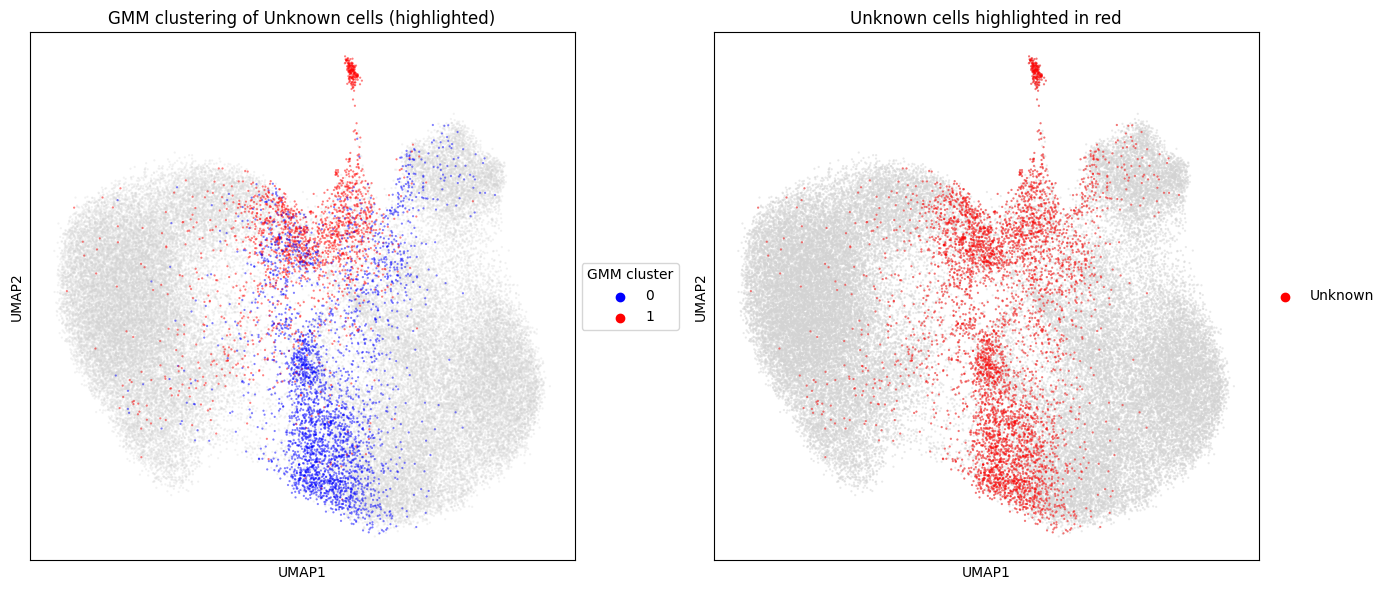

In [70]:
plot_gmm_vs_unknown_highlight(
    adata=adata_down,
    feature_key='cell_type_prediction',
    cluster_key='GMM_cluster',
    title_left='GMM clustering of Unknown cells (highlighted)',
    title_right='Unknown cells highlighted in red',
    save_path='figures/umap_gmm_unknown_highlighted.png'  # salva anche la figura)